# ¿Cuánto saldría alquilar en ...

En el notebook anterior, planteamos un problema de clasificación para predecir ocurrencia de eventos en un área urbana.

En esta oportunidad, vamos a evaluar un problema diferente. En lugar de predecir una variable discreta, vamos a querer dimensionar precios de alquiler de departamentos en la Ciudad de Buenos Aires. Es decir, una variable continua.

Para eso, vamos a trabajar con una regresión lineal. Anteriormente dijimos que la regresión logística era un tipo de regresión. Pero nunca vimos cómo era su expresión. Aprovechemos la ocasión para hacerlo ...


<p align="center">
  <img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/38_blog_image_1.png" width="50%" />
</p>

Lo que planteamos en este esquema, es la idea de una relación. La variación de nuestra variable dependiente `y` está en función del efecto que agreguen cada una de nuestras variables indepentiendtes `X`.

Así la fórmula plantea una relación lineal donde al intercepto (que es el valor de nuestra variable dependiente cuando X1,...,Xn son cero) le vamos agregando el efecto de las variables explicativas.

A diferencia de la regresión logística, acá trabajamos con un método de aproximación que se llama `OLS` (Ordinary Least Squares o Mínimos Cuadrados Ordinarios). Y como lo dice su nombre, es un método de minimización de distancias.

Es decir, que para la predicción, la regresión va a modelar una línea que será la que mejor ajuste a todos nuestros. Y la que mejor ajuste será la que minice la distancia de cada valor respecto de una tendencia media. De esta manera ...

<p align="center">
  <img src="https://www.researchgate.net/profile/Olman-Gomez-Espinoza/publication/311548169/figure/fig1/AS:614257926352896@1523461910284/Figura-3-Representacion-de-los-minimos-cuadrados.png" width="30%" /> 
</p>





In [45]:
# Instalamos dependencias
#!pip install geopandas
#!pip install rtree
#!apt install libspatialindex-dev
#!pip install mapclassify

In [2]:
from google.colab import drive
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [4]:
path = '/drive/MyDrive/Gestion de ciudades/data/censo_2010/radios_rmba.geojson'
rmba = gpd.read_file(path)
caba = rmba.loc[rmba.link.apply(lambda x: x[:2]=='02')].copy().to_crs(4326)

In [5]:
caba.columns

Index(['link', 'varon', 'mujer', 'personas', 'hogares', 'viv_part',
       'viv_part_hab', 'densidad', 'geometry'],
      dtype='object')

# Definiendo el problema

El problema que nos vamos a plantear tiene la siguiente forma. Vamos a suponer que nos interesa conocer el nivel de asequibilidad a vivienda residencial en una ciudad.

Para eso, vamos a tomar alguna división administrativa y le vamos a asignar una referencia media de precios. Digamos de departamentos en alquiler. Esto lo vamos a hacer a partir de un dataset de radios censales (polígonos) y otro de avisos de oferta (puntos).

Una vez construido el precio promedio de alquiler de departamentos por radio censal, vamos a tratar de predecir el valor de la etiqueta precio para todos aquellos radios que, por las características de nuestro dataset, no contaban con oferta.

# Exploramos variables explicativas

Ahora, ya sabemos cuál es nuestra variable `y`. Lo que vamos a querer predecir es un precio promedio para un polígono (los radios censales) a partir de una agrupación de puntos (los avisos de oferta).

Pero cuáles van a ser nuestras variables explicativas. Es decir, en función de qué vamos a intentar predecir los precios...



### Distancia a estaciones de subte

Vamos a probar algunas variables. No sabemos qué exito podemos llegar a tener, pero seleccionemos intuitivamente algunas que puedan llegar a tener alguna incidencia en el precio.

In [6]:
# levantamos un geojson de estaciones de subte
estaciones = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/sbase/subte-estaciones/estaciones-de-subte.geojson')

In [7]:
## reproyectamos nuestras capas a Gauss Krugger BsAs para tener nuestros valores de geometría en metros
proj4 = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'
estaciones = estaciones.to_crs(proj4)
caba = caba.to_crs(proj4)

In [8]:
# Calculamos la distancia a la estacion de subte mas cercana desde el centroide del radio
radio_dis = caba.geometry.apply(lambda x: estaciones.distance(x).min())
caba['subte_dis'] = radio_dis.astype(int)

### Densidad poblacional

Otra de las variables que vamos a probar es la densidad poblacional. Inicialmente esta se encuentra en formato ordinal. Es decir, un conjunto acotado de categorías ordenable de menor a mayor.

In [9]:
# Renombras para ordenar en leyenda
caba['densidad'].replace({'muy alta': '4.Muy alta','alta': '3.Alta', 
                          'media':'2.Media', 'muy baja':'1.Muy baja'}, inplace=True)

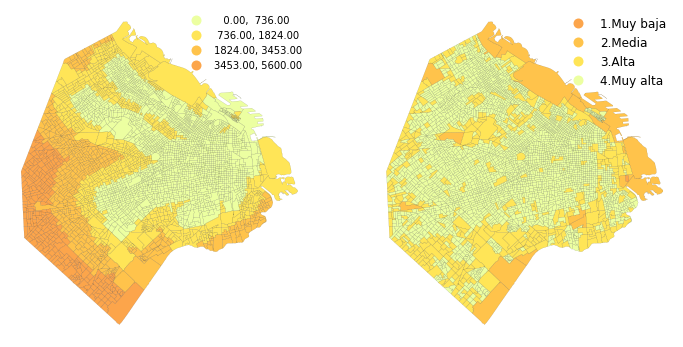

In [10]:
# Ploteamos nuestras variable explicativas
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

caba.plot(ax=ax1, column='subte_dis', 
         cmap='Wistia', scheme='naturalbreaks', k=4,
         edgecolor = 'black', linewidth = 0.1, alpha= 0.7, 
         legend=True, legend_kwds={'loc': 'upper right', 'frameon':False})

caba.plot(ax=ax2, column='densidad', 
          categorical=True, cmap='Wistia_r',
          edgecolor='black', 
          linewidth = 0.1, alpha= 0.7, 
          legend=True, legend_kwds={'fontsize':12,'frameon':False}
          )

ax1.set_axis_off()
ax2.set_axis_off();

In [11]:
# Creo densidad como numerica y dummy para densidades altas
caba['denscat'] = caba.densidad.replace({'4.Muy alta':4, '3.Alta':3, '2.Media':2, '1.Muy baja':1})

vals=[]
for i in caba.denscat:
  if i>=4:
    vals.append(1)
  else:
    vals.append(0)

caba['dens_d'] = vals

### Ubicación geográfica

Por último, agreguemos alguna referencia geográfica. Por ejemplo, la latitud y la longitud de cada aviso.

In [12]:
# Tomamos las coordenadas xy del centroide del polígono
caba['x'] = caba.geometry.centroid.x
caba['y'] = caba.geometry.centroid.y

# Target de predicción

Ahora vamos a construir nuestra variable a predecir. La mencionamos en el planteo del problema y ahora vamos a construirla.

### Precio promedio por radio censal

In [13]:
# levanto dataset de precios y me quedo con los alquileres en pesos
df = pd.read_csv('/drive/MyDrive/Gestion de ciudades/data/properati/desde_CSV/ar_properties.csv.gz')
alquileres = df.loc[df['operation_type']=='Alquiler']
alquileres_arg = alquileres.loc[alquileres['currency']=='ARS'].copy()

In [14]:
# reviso fecha de los precios
alquileres_arg.start_date.min(), alquileres_arg.start_date.max()

('2020-03-07', '2021-03-29')

In [15]:
# me quedo las publicaciones de enero a marco de 2021
alq_max_date = alquileres_arg.loc[alquileres_arg.start_date>'2021-01-01'].copy()
alq_max_date.index = range(len(alq_max_date))

In [16]:
# importamos la clase Point de shapely
from shapely.geometry import Point

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [17]:
# y creamos una geometria de puntos a partir de las coords lat/lon
alq_max_date['geom'] = alq_max_date.apply(lambda x: Point(x.lon, x.lat), axis=1)

In [18]:
# creamos un geodataframe de puntos con las publicaciones de properati
alq_max_gdf = gpd.GeoDataFrame(alq_max_date, geometry='geom', crs=4326)
# reproyectamos a gauss kruger bsas
alq_max_gkb = alq_max_gdf.to_crs(caba.crs)

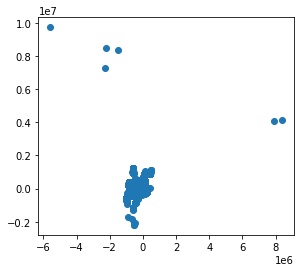

In [19]:
# nuestros avisos de oferta
alq_max_gkb.plot();

In [20]:
#con un join espacial le agregamos la etiqueta del link del radio a los puntos
alq_max_link = gpd.sjoin(alq_max_gkb, caba[['link','geometry']], predicate='within')

In [21]:
# vemos las tipologías de alquiler
alq_max_link.property_type.value_counts(normalize=True)

Departamento       0.694060
Local comercial    0.123781
Oficina            0.098730
PH                 0.039560
Depósito           0.018477
Casa               0.009748
Otro               0.008275
Cochera            0.004194
Lote               0.003174
Name: property_type, dtype: float64

In [22]:
# y nos quedamos solamente con los departamentos
alq_max_res = alq_max_link[alq_max_link['property_type'].isin(['Departamento'])].copy()

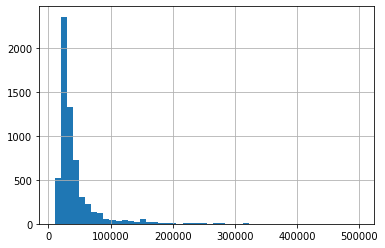

In [23]:
# distribucion de precios
alq_max_res.price.hist(bins=50);

In [24]:
alq_max_res.price.describe()

count      6123.000000
mean      41627.812510
std       36851.601349
min       10000.000000
25%       24000.000000
50%       30000.000000
75%       44000.000000
max      500000.000000
Name: price, dtype: float64

In [25]:
# creamos un promedio de precios de departamentos en alquiler por radio censal
alq_avg = alq_max_res.groupby('link')['price'].mean()

In [26]:
# creamos un nuevo dataset, pegando la serie de precios a nuestro gdf de radios
caba_ = caba.set_index('link').join(alq_avg).copy()

In [27]:
# excluimos valores extremos
caba_f = caba_.loc[caba_.price < 150000].copy()

Acá vemos mejor nuestro problema. Dado que no contabamos con oferta para todo el territorio de la ciudad, muchos radios censales quedaron sin un valor de referencia. 

Y esto es justamente lo que vamos a predecir, ¿cuál es el valor promedio de un departamento en alquiler en las zonas donde no registramos oferta?

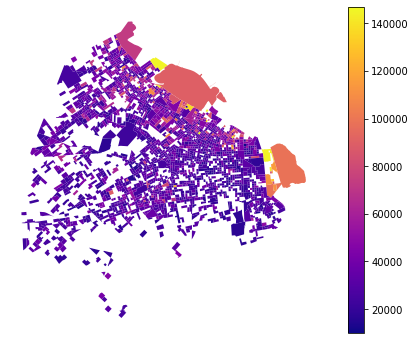

In [28]:
# ploteamos el precio promedio por radio censal
f,ax=plt.subplots(figsize=(10,6))
caba_f.plot(column='price', legend=True, cmap='plasma', ax=ax)
ax.set_axis_off();

# Construyendo el modelo

Para estimar nuestra relación lineal, vamos a trabajar con `statsmodels`, una [librería](https://www.statsmodels.org/stable/index.html) que proporciona clases y funciones para la estimación de modelos y tests estadísticos.

In [29]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
warnings.filterwarnings("ignore", message='In a future version of pandas all arguments of concat*')

In [31]:
# nuestras variables x
caba_f.columns

Index(['varon', 'mujer', 'personas', 'hogares', 'viv_part', 'viv_part_hab',
       'densidad', 'geometry', 'subte_dis', 'denscat', 'dens_d', 'x', 'y',
       'price'],
      dtype='object')

In [32]:
# planteamos el modelo y lo instanciamos
regresores = ['dens_d','subte_dis','x','y']
x = caba_f[regresores]
y = caba_f['price']

x = sm.add_constant(x) #agregamos el intercepto
model = sm.OLS(y, x).fit()

In [33]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     65.12
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           7.70e-52
Time:                        12:36:05   Log-Likelihood:                -22368.
No. Observations:                2010   AIC:                         4.475e+04
Df Residuals:                    2005   BIC:                         4.477e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.805e+05   2.46e+04    -11.412      0.0

Lo que imprimimos arriba es un resúmen de performance de nuestra regresión lineal.

Para poder interpretarlo debemos tener en cuenta el R2 ajustado del modelo. Este nos indica el porcentaje de variabilidad que llegamos a explicar sobre nuestra variable dependiente. Digamos que es lo que nos indica cuan bien o mal ajusta nuestro modelo. 

Los resultados van de 0 a 1. Y por lo que vemos, nuestra regresión no está siendo muy efectiva. Sólo puede explicar un 11% de la variabilidad del precio promedio a lo largo de todos los radios que usamos para entrenar.

Pero, no solamente la capacidad explicativa es baja. El valor del intercepto también es negativo. Esto no necesariamente sea algo que esté mal, pero debería ser una pista sobre cómo performa nuestro modelo. 

Que el valor de un departamento sin el efecto de las demás variables esté en el cuadrante negativo de la recta podría estar indicandonos algún problema en el pre-processing de nuestra data, que estamos omitiendo variables relevantes o simplemente que nuestra relación no es lineal. 

Respecto del componente determinístico, vemos que todas las variables son significativas. En áreas más densas, el valor promedio del alquiler parecería estar unos ARS4119 abajo. 

Por su parte, las variables continuas muestran que los precios crecen ARS2.4, ARS0.8 y ARS2.3 por cada unidad adicional de distancia (1 metro). Algo que parece un poco contraintuitivo. 

Veamos esto un poco más en detalle cómo funcionala predicción...

In [34]:
# Probamos cómo predice nuestra regresión
test_pred = model.predict(x)

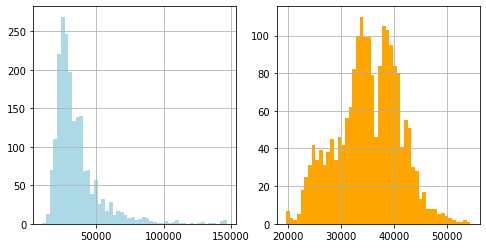

In [35]:
# Y evaluamos cuan distinta es la serie de precios predicha 
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
caba_f.price.hist(ax=ax1, color='lightblue', bins=50)
test_pred.hist(ax=ax2, color='orange', bins=50);

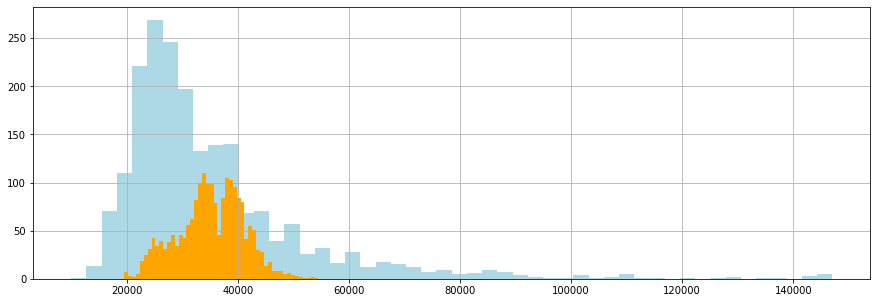

In [36]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
caba_f.price.hist(ax=ax, color='lightblue', bins=50)
test_pred.hist(ax=ax, color='orange',bins=50);

Lo primero que podemos ver es que la distribución que obtenemos con la predicción no sólo se encuentra en un rango de valores más acotados. 

También parece seguir una distribución más parecida a una normal con dos modas. Si bien se encuentra en la región de la distribución observada, sigue un comportamiento algo diferente. 

En definitiva, lo que predice nuestro modelo sólo alcanza a explicar una parte del universo observado. Ahora, ¿Cómo lo hace? 

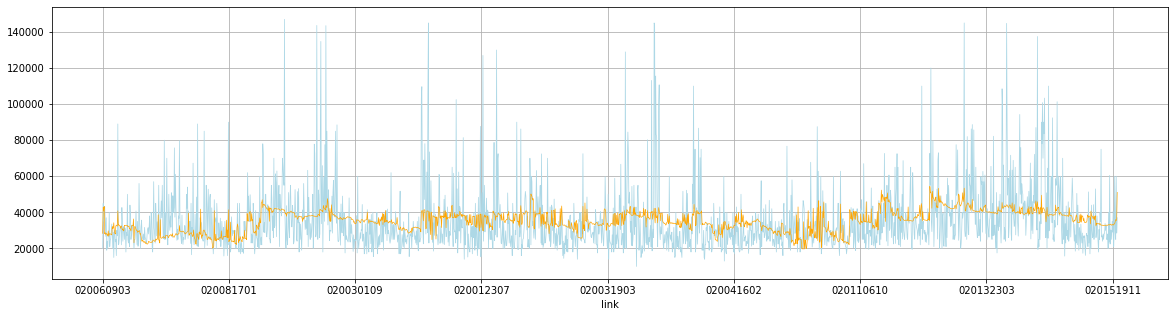

In [37]:
# ahora vemos el precio radio a radio
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
caba_f.price.plot(kind='line', ax=ax, color='lightblue', linewidth=0.75)
test_pred.plot(kind='line',ax=ax, color='orange', linewidth=0.65)
plt.grid();

Lo que vemos acá es que la predicción parece respetar una tendencia, aunque las diferencias en algunas regiones es muy alta. Es decir, algunos de los valores de los que predecimos se acercan más a lo observado, mientras que otros están muy lejos. 



# Prediciendo el el valor de los alquileres

Ahora sabemos que no podemos esperar mucho de este modelo. De todos modos, veamos cómo utilizarlo para responder nuestra pregunta inicial ...

In [38]:
# Recuperamos los radios sin valor promedio
caba_pred = caba_[~caba_.index.isin(caba_f.index)][regresores]
# agregamos la constante, o valor de y cuando las x son igual a 0
caba_pred = sm.add_constant(caba_pred)

In [39]:
# predecimos el valor medio de un alquiler para los radios censales sin oferta
predicciones = model.predict(caba_pred)

In [40]:
predicciones

link
020132304    40220.542597
020142804    39157.635095
020052003    28073.196106
020052005    27955.136632
020052006    28204.450168
                 ...     
020151707    32709.860290
020151806    32709.224270
020151808    33026.549419
020151810    32912.908312
020151908    32933.519294
Length: 1543, dtype: float64

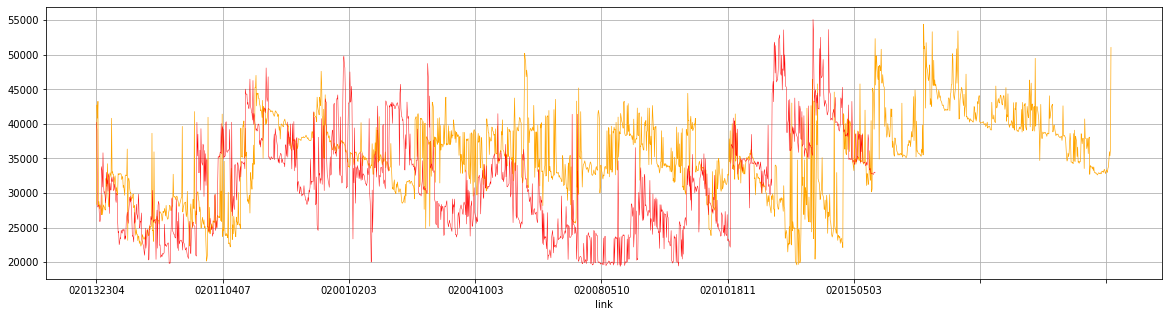

In [41]:
# comparamos con la predicción anterior
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
test_pred.plot(kind='line',ax=ax, color='orange', linewidth=0.65)
predicciones.plot(kind='line', ax=ax, color='red', linewidth=0.45)
plt.grid();

In [42]:
# creamos un nuevo dataset con los valores predichos para los radios sin oferta unicamente
predichos = caba_[~caba_.index.isin(caba_f.index)].copy()
predichos['price'] = predichos.index.map(predicciones)

In [43]:
# concatenamos ambos dataset, los radios con y sin(los predichos) oferta
caba_alq = pd.concat([caba_f, predichos]).copy()

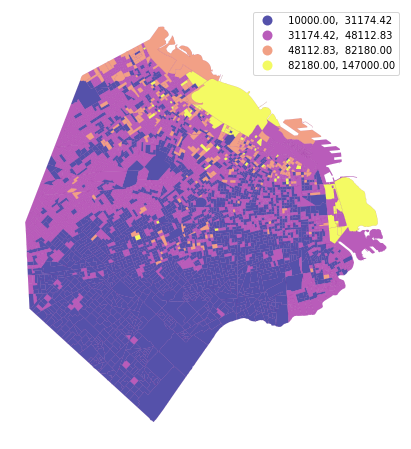

In [44]:
# así es como predice una regresión lineal sin mucha curaduría
f, ax = plt.subplots(figsize=(12,8))

caba_alq.plot(ax=ax, column='price', 
              cmap='plasma', scheme='naturalbreaks', k=4,
              edgecolor = 'purple', linewidth = 0.1, alpha= 0.7, 
              legend=True, legend_kwds={'loc': 'upper right'})
ax.set_axis_off();

# Ejerciatión sugerida

* Revisar las variables explicativas y/o agregar nuevas en el geodataframe de radios. Por ejemplo, distancia a algún atributo urbano, métricas de accesibilidad, etc.

* Evaluar un nuevo R2 con las modificaciones del punto anterior.